# Importer les données

In [5]:
!kaggle competitions download -c spaceship-titanic


  0%|          | 0.00/299k [00:00<?, ?B/s]
100%|##########| 299k/299k [00:00<00:00, 998kB/s]
100%|##########| 299k/299k [00:00<00:00, 998kB/s]


In [7]:
!tar  -xf spaceship-titanic.zip

In [4]:
import pandas as pd
import numpy as np
input_train = pd.read_csv("train.csv", index_col=0)
input_train

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
PassengerId,,,,,,,,,,,,,
0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False
9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False
9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True


## Nettoyer le train set

In [5]:
print(input_train.isna().values.any())
n_col = len(input_train.columns)
# input_train = pd.DataFrame.dropna(input_train, axis='index')
input_train.fillna(inplace=True, axis=0, method='pad')
print(input_train.isna().values.any())

# je choisir de faire un pad car si je choisis la méthode qui vire toutes les lignes contenant des nan, les types des colonnes ne sont pas ramenés à leur unique valeur (i.e. sont labellées comme objects et non bool par exemple)

True
False


In [6]:
input_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8693 entries, 0001_01 to 9280_02
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    8693 non-null   object 
 1   CryoSleep     8693 non-null   bool   
 2   Cabin         8693 non-null   object 
 3   Destination   8693 non-null   object 
 4   Age           8693 non-null   float64
 5   VIP           8693 non-null   bool   
 6   RoomService   8693 non-null   float64
 7   FoodCourt     8693 non-null   float64
 8   ShoppingMall  8693 non-null   float64
 9   Spa           8693 non-null   float64
 10  VRDeck        8693 non-null   float64
 11  Name          8693 non-null   object 
 12  Transported   8693 non-null   bool   
dtypes: bool(3), float64(6), object(4)
memory usage: 772.5+ KB


## Scinder la colonne `Cabin` textuelle en trois catégories deck, number, side

In [8]:
import re as regex
def scinder_deck(dataframe):
    val_cab = dataframe.loc[:, "Cabin"].values
    index = dataframe.index
    import re as regex
    decks = []
    nums = []
    sides = []
    for cabin in val_cab:
        match = regex.search(r'([A-Z])\/([0-9]*)\/([PS])', cabin)
        deck = match.group(1)
        num  = match.group(2)
        side = match.group(3)
        decks.append(deck)
        nums.append(int(num))
        sides.append(True if side=='P' else False) # car seulement deux côtés
    assert len(decks) == len(dataframe.index)
    dataframe["Cabin_Deck"] = decks
    dataframe["Cabin_Num"]  = nums
    dataframe["Cabin_Side"] = sides
    
    
scinder_deck(input_train)

In [9]:
input_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8693 entries, 0001_01 to 9280_02
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    8693 non-null   object 
 1   CryoSleep     8693 non-null   bool   
 2   Cabin         8693 non-null   object 
 3   Destination   8693 non-null   object 
 4   Age           8693 non-null   float64
 5   VIP           8693 non-null   bool   
 6   RoomService   8693 non-null   float64
 7   FoodCourt     8693 non-null   float64
 8   ShoppingMall  8693 non-null   float64
 9   Spa           8693 non-null   float64
 10  VRDeck        8693 non-null   float64
 11  Name          8693 non-null   object 
 12  Transported   8693 non-null   bool   
 13  Cabin_Deck    8693 non-null   object 
 14  Cabin_Num     8693 non-null   int64  
 15  Cabin_Side    8693 non-null   bool   
dtypes: bool(4), float64(6), int64(1), object(5)
memory usage: 916.8+ KB


In [10]:
# regarder les valeurs prises par une colonne
input_train["VIP"].unique()

array([False,  True])

## Créer la colonne prédite: `Transported`

In [11]:
train_labels = input_train.loc[:,"Transported"]

## Fabriquer la matrice de corrélation

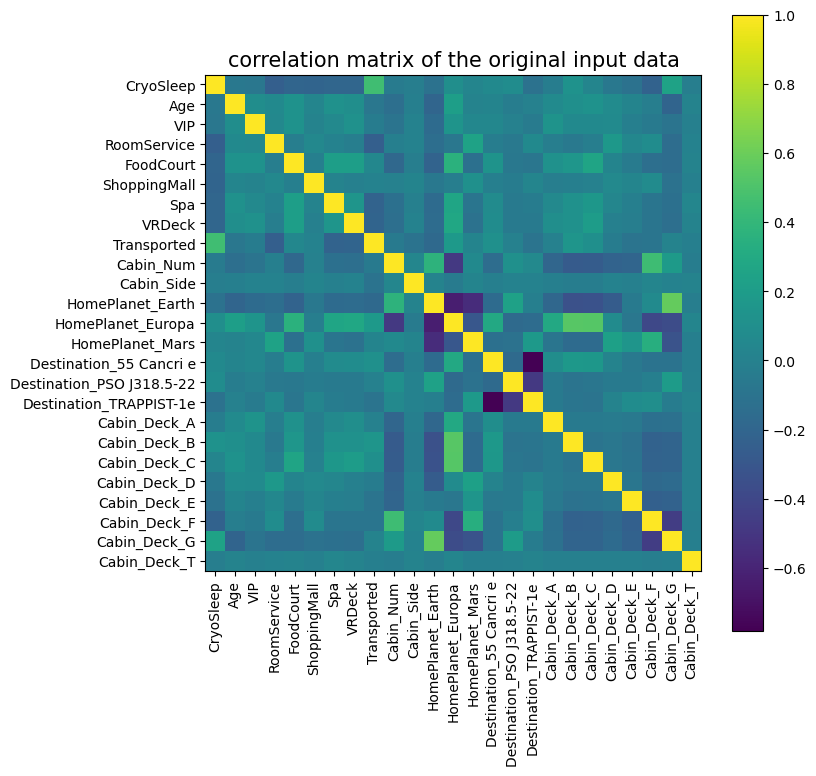

In [12]:
import matplotlib.pyplot as plt
input_train_correlation = input_train.drop(labels=['Name', 'Cabin'], axis=1)
correlation_set = pd.get_dummies(input_train_correlation) 


mat_corr = correlation_set.corr()
labels = list(mat_corr.index)
mat_corr_np = np.array(mat_corr)

plt.figure(figsize = (8,8))
plt.imshow(mat_corr_np, cmap='viridis')
plt.colorbar()
plt.xticks(range(len(mat_corr.index)), labels, rotation='vertical', fontsize=10)
plt.yticks(range(len(mat_corr.index)), labels, rotation='horizontal', fontsize=10)
plt.title('correlation matrix of the original input data', size=15)
plt.show()

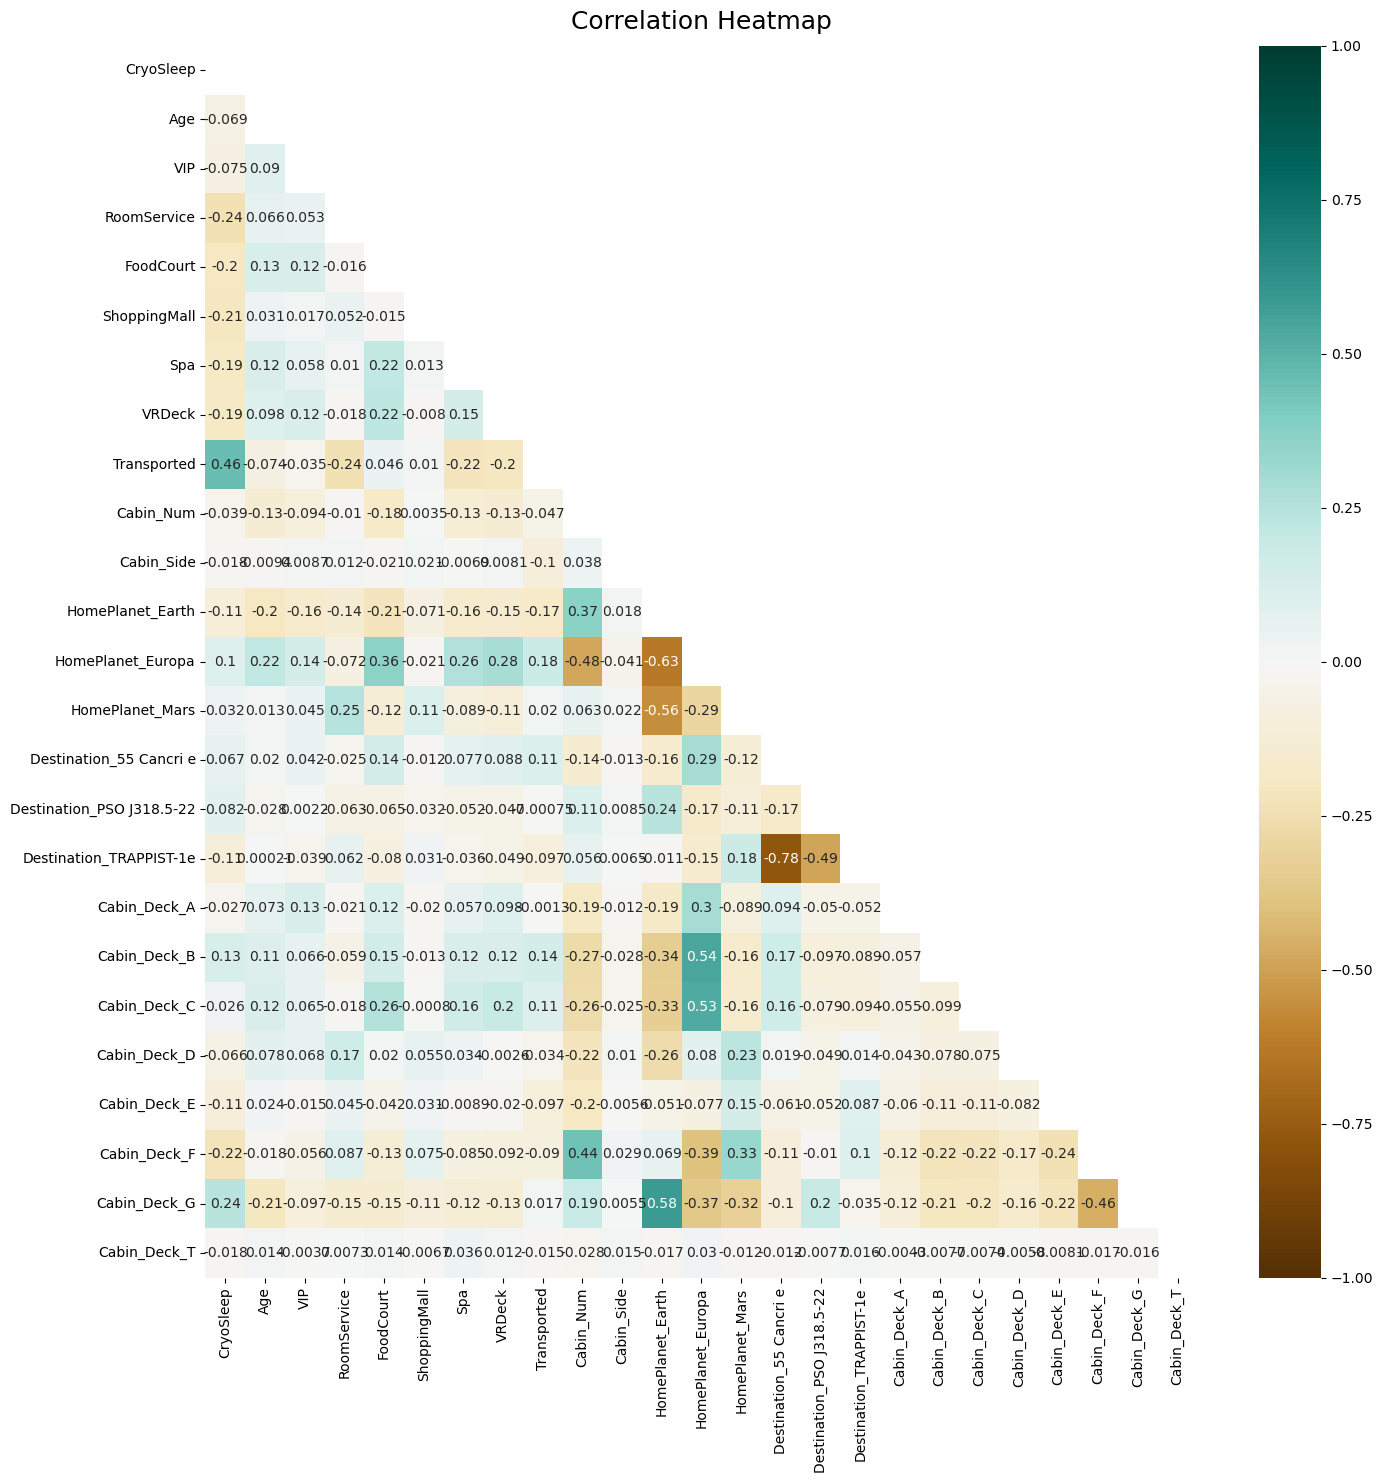

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 16))
mat_corr = correlation_set.corr()
mask = np.triu(np.ones_like(mat_corr, dtype=bool))
heatmap = sns.heatmap(mat_corr, vmin=-1, vmax=1, annot=True, cmap='BrBG', mask=mask)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12);

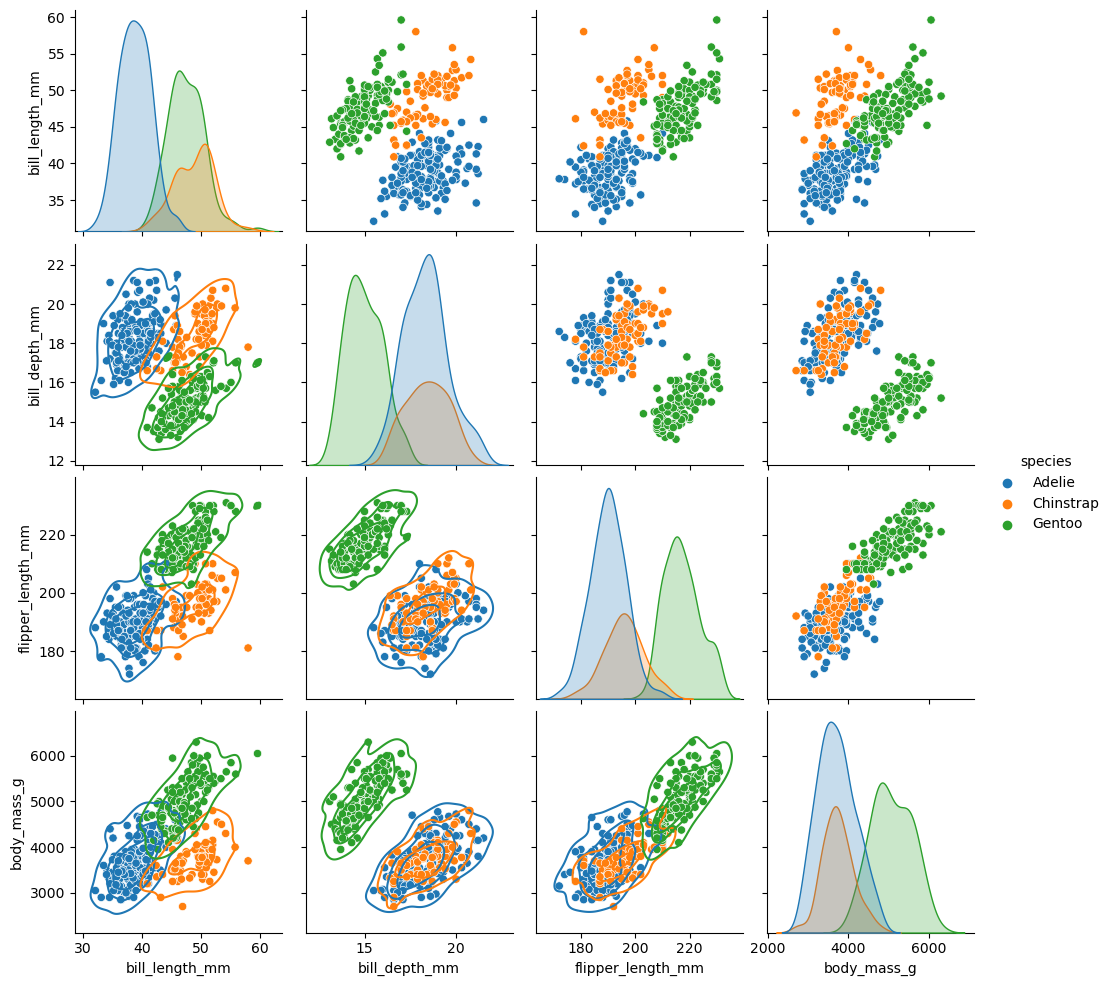

In [14]:
penguins = sns.load_dataset("penguins")
g = sns.pairplot(penguins, hue="species")
g.map_lower(sns.kdeplot, levels=4, color=".2")

## Numériser les features d'entraînement textuelles par un one-hot encoding

In [16]:
input_train_featured = input_train.drop(labels=['Name', 'Cabin', 'Transported'], axis=1)
train_features = pd.get_dummies(input_train_featured) 
train_features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8693 entries, 0001_01 to 9280_02
Data columns (total 24 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   CryoSleep                  8693 non-null   bool   
 1   Age                        8693 non-null   float64
 2   VIP                        8693 non-null   bool   
 3   RoomService                8693 non-null   float64
 4   FoodCourt                  8693 non-null   float64
 5   ShoppingMall               8693 non-null   float64
 6   Spa                        8693 non-null   float64
 7   VRDeck                     8693 non-null   float64
 8   Cabin_Num                  8693 non-null   int64  
 9   Cabin_Side                 8693 non-null   bool   
 10  HomePlanet_Earth           8693 non-null   uint8  
 11  HomePlanet_Europa          8693 non-null   uint8  
 12  HomePlanet_Mars            8693 non-null   uint8  
 13  Destination_55 Cancri e    8693 non-null   u

# Utiliser des RandomForests et XGBoost
## Fitting RandomForest

In [17]:
from sklearn.ensemble import RandomForestClassifier
N_est = 1000
rfc = RandomForestClassifier(n_estimators = N_est, random_state = 42)

In [18]:
rfc.fit(train_features, train_labels)

RandomForestClassifier(n_estimators=1000, random_state=42)

## Fitting XGBoost

In [19]:
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier()
gbc.fit(train_features, train_labels)

GradientBoostingClassifier()

## Fitting SVM

In [20]:
from sklearn import svm
svc = svm.SVC(kernel='poly', degree=3)
svc.fit(train_features, train_labels)
# svr = svm.SVR() # regression donc non
# svr.fit(train_features, train_labels)

SVC(kernel='poly')

## Importer le test set

In [21]:
input_test = pd.read_csv("test.csv", index_col=0)
input_test.info(verbose=True)
input_test.isna().values.any()

<class 'pandas.core.frame.DataFrame'>
Index: 4277 entries, 0013_01 to 9277_01
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    4190 non-null   object 
 1   CryoSleep     4184 non-null   object 
 2   Cabin         4177 non-null   object 
 3   Destination   4185 non-null   object 
 4   Age           4186 non-null   float64
 5   VIP           4184 non-null   object 
 6   RoomService   4195 non-null   float64
 7   FoodCourt     4171 non-null   float64
 8   ShoppingMall  4179 non-null   float64
 9   Spa           4176 non-null   float64
 10  VRDeck        4197 non-null   float64
 11  Name          4183 non-null   object 
dtypes: float64(6), object(6)
memory usage: 434.4+ KB


True

## Nettoyer le test set

In [22]:
input_test.fillna(inplace=True, axis=0, method='pad')
# input_test.info(verbose=True)
# input_test.isna().any()

## Retraiter les données de cabine sur le test set

In [23]:
scinder_deck(input_test)

In [24]:
test_features = pd.get_dummies(input_test.drop(labels=['Name', 'Cabin'], axis=1))
test_features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4277 entries, 0013_01 to 9277_01
Data columns (total 24 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   CryoSleep                  4277 non-null   bool   
 1   Age                        4277 non-null   float64
 2   VIP                        4277 non-null   bool   
 3   RoomService                4277 non-null   float64
 4   FoodCourt                  4277 non-null   float64
 5   ShoppingMall               4277 non-null   float64
 6   Spa                        4277 non-null   float64
 7   VRDeck                     4277 non-null   float64
 8   Cabin_Num                  4277 non-null   int64  
 9   Cabin_Side                 4277 non-null   bool   
 10  HomePlanet_Earth           4277 non-null   uint8  
 11  HomePlanet_Europa          4277 non-null   uint8  
 12  HomePlanet_Mars            4277 non-null   uint8  
 13  Destination_55 Cancri e    4277 non-null   u

## Predict & Submit les RandomForest, XGBoost, SVM

In [25]:
predict = pd.DataFrame(svc.predict(test_features), index=input_test.index, columns=["Transported"])
predict

,Transported
PassengerId,
0013_01,True
0018_01,True
0019_01,True
0021_01,True
0023_01,True
...,...
9266_02,True
9269_01,True
9271_01,True


In [26]:
predict.to_csv("./predict.csv")

In [86]:
!kaggle competitions submit -c spaceship-titanic -f "predict.csv" -m "SVR_sklearn"

^C
Successfully submitted to Spaceship Titanic



  0%|          | 0.00/59.4k [00:00<?, ?B/s]
100%|##########| 59.4k/59.4k [00:01<00:00, 42.0kB/s]


# Utiliser un réseau neuronal
## Création des colonnes `train_features_nn`, conversion en `float32`

In [27]:
train_features_nn = train_features.copy()

for col_name in train_features_nn.columns:
    train_features_nn[col_name] = train_features_nn[col_name].astype('float32')
train_features_nn.describe()

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Cabin_Num,Cabin_Side,...,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,Cabin_Deck_A,Cabin_Deck_B,Cabin_Deck_C,Cabin_Deck_D,Cabin_Deck_E,Cabin_Deck_F,Cabin_Deck_G,Cabin_Deck_T
count,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,...,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000
mean,0.357874,28.814449,0.023467,224.358902,459.524200,171.978836,311.027710,304.271698,598.691345,0.496606,...,0.093869,0.694467,0.030599,0.092373,0.087887,0.055792,0.103186,0.327505,0.302082,0.000575
std,0.479399,14.495526,0.151387,663.211243,1611.285767,598.891235,1135.411377,1148.839722,511.749664,0.500015,...,0.291654,0.460668,0.172233,0.289580,0.283154,0.229533,0.304206,0.469345,0.459197,0.023978
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,166.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,425.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,38.000000,0.000000,48.000000,77.000000,26.000000,61.000000,44.000000,996.000000,1.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
max,1.000000,79.000000,1.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000,1894.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Normalisation des colonnes `train_features_nn`

In [28]:
import sklearn.preprocessing
std_scalar     = sklearn.preprocessing.StandardScaler()
min_max_scalar = sklearn.preprocessing.MinMaxScaler()
def normalize_input(df, col_to_norm):
    x = df[col_to_norm].values
    x_scaled = min_max_scalar.fit_transform(x)
    df_temp = pd.DataFrame(x_scaled, columns=col_to_norm, index = df.index)
    df[col_to_norm] = df_temp

In [29]:
column_names_to_normalize = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Cabin_Num']
normalize_input(train_features_nn, column_names_to_normalize)
train_features_nn.describe()

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Cabin_Num,Cabin_Side,...,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,Cabin_Deck_A,Cabin_Deck_B,Cabin_Deck_C,Cabin_Deck_D,Cabin_Deck_E,Cabin_Deck_F,Cabin_Deck_G,Cabin_Deck_T
count,8693.000000,8693.000000,8693.000000,8693.00000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,...,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000
mean,0.357874,0.364741,0.023467,0.01566,0.015414,0.007321,0.013880,0.012608,0.316099,0.496606,...,0.093869,0.694467,0.030599,0.092373,0.087887,0.055792,0.103186,0.327505,0.302082,0.000575
std,0.479399,0.183489,0.151387,0.04629,0.054050,0.025493,0.050671,0.047605,0.270195,0.500015,...,0.291654,0.460668,0.172233,0.289580,0.283154,0.229533,0.304206,0.469345,0.459197,0.023978
min,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.240506,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.087645,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.341772,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.224393,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.481013,0.000000,0.00335,0.002583,0.001107,0.002722,0.001823,0.525871,1.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Création de  la colonne `train_labels_nn` en `float32` doublée pour 2 états pour le NN

In [30]:
train_labels_nn = pd.DataFrame()
train_labels_nn["Transported_false"] = (1-(input_train["Transported"])).astype('float32') # faux en premier pour 0 avec argmax
train_labels_nn["Transported_true"]  = input_train["Transported"].astype('float32')       # vrai en second  pour 1 avec argmax

train_labels_nn

,Transported_false,Transported_true
PassengerId,,
0001_01,1.0,0.0
0002_01,0.0,1.0
0003_01,1.0,0.0
0003_02,1.0,0.0
0004_01,0.0,1.0
...,...,...
9276_01,1.0,0.0
9278_01,1.0,0.0
9279_01,0.0,1.0


In [31]:
train_features_nn[6:10]

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Cabin_Num,Cabin_Side,...,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,Cabin_Deck_A,Cabin_Deck_B,Cabin_Deck_C,Cabin_Deck_D,Cabin_Deck_E,Cabin_Deck_F,Cabin_Deck_G,Cabin_Deck_T
PassengerId,,,,,,,,,,,,,,,,,,,,,
0006_01,0.0,0.329114,0.0,0.002932,0.051622,0.000128,0.000000,0.0,0.001056,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
0006_02,1.0,0.354430,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
0007_01,0.0,0.443038,0.0,0.000000,0.026331,0.000724,0.009639,0.0,0.001584,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
0008_01,1.0,0.177215,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000528,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


## Conversion des `train_features` et `train_labels` en arrays numpy

In [32]:
train_features_nn_ar = train_features_nn.to_numpy()
train_labels_nn_ar   = train_labels_nn.to_numpy()

## Création et entraînement du réseau

In [33]:
import tensorflow as tf
from tensorflow import keras

model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(32, activation='tanh'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(2, activation='tanh'))
# model.add(tf.keras.layers.Softmax())
model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=['accuracy'])
# les logits sont la raw pred: https://stackoverflow.com/a/50511692

history = model.fit(train_features_nn_ar, train_labels_nn_ar, batch_size=128, epochs=100) #, validation_split=.2
model.summary()

Epoch 1/100
68/68 [==============================] - 2s 4ms/step - loss: 0.6833 - accuracy: 0.5958
Epoch 2/100
68/68 [==============================] - 0s 5ms/step - loss: 0.5857 - accuracy: 0.7168
Epoch 3/100
68/68 [==============================] - 0s 4ms/step - loss: 0.5615 - accuracy: 0.7476
Epoch 4/100
68/68 [==============================] - 0s 4ms/step - loss: 0.5530 - accuracy: 0.7537
Epoch 5/100
68/68 [==============================] - 0s 5ms/step - loss: 0.5477 - accuracy: 0.7585
Epoch 6/100
68/68 [==============================] - 0s 4ms/step - loss: 0.5421 - accuracy: 0.7635
Epoch 7/100
68/68 [==============================] - 0s 4ms/step - loss: 0.5381 - accuracy: 0.7699
Epoch 8/100
68/68 [==============================] - 0s 4ms/step - loss: 0.5340 - accuracy: 0.7733
Epoch 9/100
68/68 [==============================] - 0s 5ms/step - loss: 0.5293 - accuracy: 0.7787
Epoch 10/100
68/68 [==============================] - 0s 5ms/step - loss: 0.5256 - accuracy: 0.7766
Epoch 11/

## Courbes d'entraînement

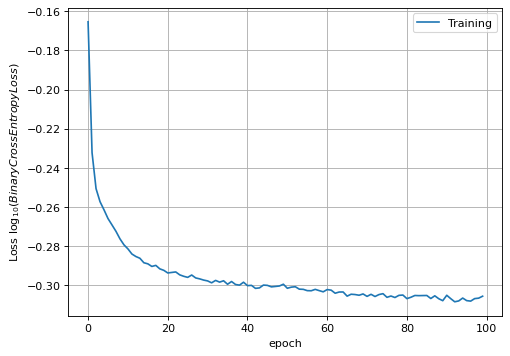

In [34]:
plt.figure(figsize=(7, 5), dpi=80)
plt.plot(np.log10(history.history['loss']))
# plt.plot(np.log10(history.history['val_loss']))
#plt.title('model loss')
plt.ylabel(r'Loss $\log_{10}(Binary Cross Entropy Loss)$')
plt.xlabel('epoch')
plt.legend(['Training', 'Test'])
plt.grid()
plt.show()

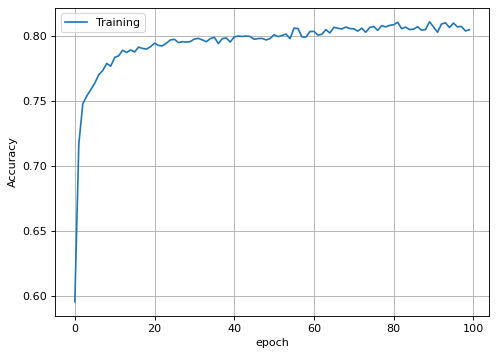

In [35]:
plt.figure(figsize=(7, 5), dpi=80)
plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
#plt.title('model loss')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['Training', 'Test'])
plt.grid()
plt.show()

## Tests de prédiction du NN sur les données d'entraînement

In [36]:
y_pred = tf.keras.layers.Softmax()(model.predict(train_features_nn_ar[1:100,:])).numpy()

In [37]:
y_true = train_labels_nn.values[1:100,:]

In [38]:
tf.keras.backend.argmax(train_labels_nn.values[50:70,:])

<tf.Tensor: shape=(20,), dtype=int64, numpy=
array([0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0],
      dtype=int64)>

In [39]:
tf.keras.backend.argmax(model.predict(train_features_nn_ar[50:70,:]))

<tf.Tensor: shape=(20,), dtype=int64, numpy=
array([0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0],
      dtype=int64)>

In [722]:
# mesurons la categorical binary entropy
bce = tf.keras.losses.BinaryCrossentropy(from_logits=False)
bce(y_true, y_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=0.5771105>

## Tests de prédiction sur les données de test à submit
### Même traitement sur le test set que sur le train set pour l'entrée dans le réseau
On commence par convertir toutes les colonnes en `Float32` et ensuite on normalise les colonnes qui doivent l'être

In [678]:
test_features_nn = test_features.copy()

column_names_to_normalize = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Cabin_Num']
normalize_input(test_features_nn, column_names_to_normalize)

for col_name in test_features_nn.columns:
    test_features_nn[col_name] = test_features_nn[col_name].astype('float32')
    
    
normalize_input(test_features_nn, column_names_to_normalize)

test_features_nn_ar = test_features_nn.to_numpy()

In [679]:
test_features_nn

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Cabin_Num,Cabin_Side,...,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,Cabin_Deck_A,Cabin_Deck_B,Cabin_Deck_C,Cabin_Deck_D,Cabin_Deck_E,Cabin_Deck_F,Cabin_Deck_G,Cabin_Deck_T
PassengerId,,,,,,,,,,,,,,,,,,,,,
0013_01,1.0,0.341772,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.001587,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
0018_01,0.0,0.240506,0.0,0.000000,0.000356,0.00000,0.142260,0.000000,0.002116,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
0019_01,1.0,0.392405,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
0021_01,0.0,0.481013,0.0,0.000000,0.263206,0.00000,0.009121,0.026266,0.000529,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
0023_01,0.0,0.253165,0.0,0.000865,0.000000,0.07658,0.000000,0.000000,0.002646,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9266_02,1.0,0.430380,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.791534,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
9269_01,0.0,0.531646,0.0,0.000000,0.033514,0.00205,0.000504,0.006466,0.791534,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
9271_01,1.0,0.531646,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.156614,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


## Predict & submit les prédictions du NN

In [686]:
predictions = model.predict(test_features_nn_ar)
distributions = tf.keras.layers.Softmax()(predictions)

In [688]:
distributions.numpy()

array([[0.59181446, 0.4081855 ],
       [0.880797  , 0.11920292],
       [0.11920294, 0.880797  ],
       ...,
       [0.12435611, 0.8756439 ],
       [0.15883377, 0.84116626],
       [0.12377638, 0.87622356]], dtype=float32)

In [691]:
transports = tf.keras.backend.argmax(distributions)

In [693]:
predict = pd.DataFrame(transports, index=input_test.index, columns=["Transported"])

In [694]:
predict.to_csv("./predict.csv")

In [695]:
!kaggle competitions submit -c spaceship-titanic -f "predict.csv" -m "SVM"

Successfully submitted to Spaceship Titanic



  0%|          | 0.00/46.0k [00:00<?, ?B/s]
 17%|#7        | 8.00k/46.0k [00:00<00:00, 53.1kB/s]
100%|##########| 46.0k/46.0k [00:01<00:00, 24.3kB/s]


# Visualiser toutes les features sans exception
On crée un DataFrame appelé `input_train_viz` conçu pour les visualisations spécialement

<class 'pandas.core.frame.DataFrame'>
Index: 8693 entries, 0001_01 to 9280_02
Data columns (total 25 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   CryoSleep                  8693 non-null   bool   
 1   Age                        8693 non-null   float64
 2   VIP                        8693 non-null   bool   
 3   RoomService                8693 non-null   float64
 4   FoodCourt                  8693 non-null   float64
 5   ShoppingMall               8693 non-null   float64
 6   Spa                        8693 non-null   float64
 7   VRDeck                     8693 non-null   float64
 8   Transported                8693 non-null   bool   
 9   Cabin_Num                  8693 non-null   int64  
 10  Cabin_Side                 8693 non-null   bool   
 11  HomePlanet_Earth           8693 non-null   uint8  
 12  HomePlanet_Europa          8693 non-null   uint8  
 13  HomePlanet_Mars            8693 non-null   u

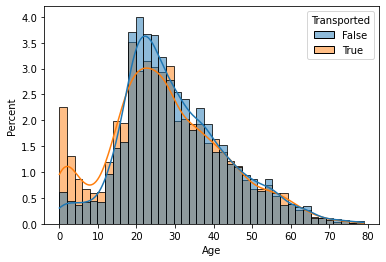

In [31]:
input_train_viz = input_train.drop(labels=['Name', 'Cabin'], axis=1)
input_train_viz = pd.get_dummies(input_train_viz) 
input_train_viz.info()

import seaborn as sns
sns.histplot(x='Age', data=input_train_viz, hue='Transported', bins=40, stat="percent", legend=True, kde=True)

for col_name in input_train_viz.columns:
    input_train_viz[col_name] = input_train_viz[col_name].astype('float32')

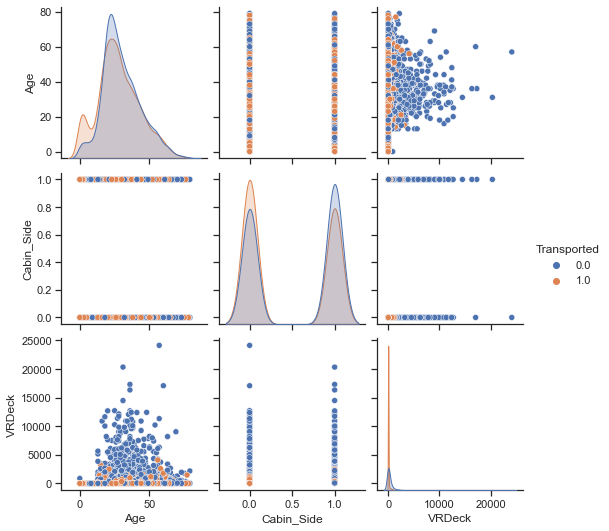

In [32]:
import seaborn as sns
sns.set_theme(style="ticks")

# sns.pairplot(input_train_viz.drop(labels=input_train_viz.columns[9:17], axis=1), hue="Transported")
sns.pairplot(input_train_viz.loc[:,["Age","Cabin_Side", "VRDeck", "Transported"]], hue="Transported")

## Faire une PCA des données et montrer quelles features sont prises en compte le plus
On normalise les données avant

In [33]:
import sklearn.preprocessing
std_scalar     = sklearn.preprocessing.StandardScaler()
min_max_scalar = sklearn.preprocessing.MinMaxScaler()

def normalize_input(df, col_to_norm):
    x = df[col_to_norm].values
    x_scaled = min_max_scalar.fit_transform(x)
    df_temp = pd.DataFrame(x_scaled, columns=col_to_norm, index = df.index)
    df[col_to_norm] = df_temp

normalize_input(input_train_viz, input_train_viz.columns)


from sklearn.decomposition import PCA
pca = PCA(n_components=2)
input_train_viz_ch = input_train_viz.drop(labels=["Transported"], axis=1)
input_train_viz_np = input_train_viz_ch.to_numpy()
pca.fit(input_train_viz_np)

PCA(n_components=2)

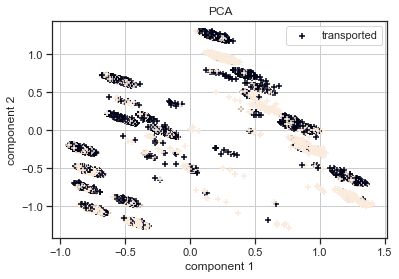

In [34]:
vect = pca.fit_transform(input_train_viz_np)
plt.scatter(vect[:,0], vect[:,1], c=input_train_viz['Transported'].to_numpy(), marker='+', label="transported")
plt.grid(True)
plt.title('PCA')
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.legend()

## Les 2 vecteurs propres qui discriminent les données le plus et leurs features associées

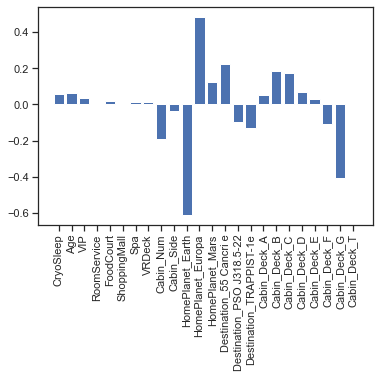

In [35]:
plt.bar(input_train_viz_ch.columns, pca.components_[0,:])
plt.xticks(rotation=90)
plt.show()

In [36]:
pca.explained_variance_

array([0.5419713, 0.4476889], dtype=float32)

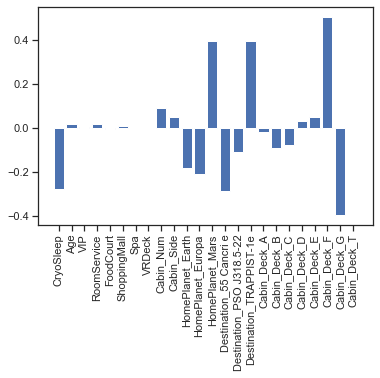

In [37]:
plt.bar(input_train_viz_ch.columns, pca.components_[1,:])
plt.xticks(rotation=90)
plt.show()

In [38]:
from sklearn.manifold import TSNE

In [39]:
tsne = TSNE(n_components=2, random_state=0, perplexity=15)
rd_flat_vect = tsne.fit_transform(input_train_viz_np)

C:\Users\matth\.conda\envs\tf\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\matth\.conda\envs\tf\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


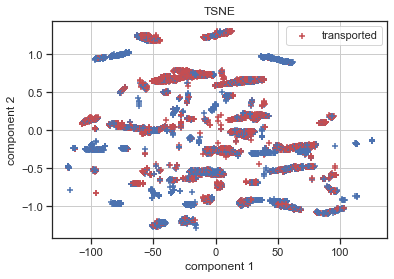

In [40]:
colormap = np.array(['r', 'b'])
categories = input_train_viz['Transported'].to_numpy().astype(int)

plt.scatter(rd_flat_vect[:,0], vect[:,1], c=colormap[categories], marker='+', label="transported")
plt.grid(True)
plt.title('TSNE')
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.legend()